In [1]:
import findspark

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt

In [2]:
# 1. Create a new SparkSession
spark = SparkSession.builder.appName("TwitterTrends").master("local[2]").getOrCreate()

# 2. Create a new StreamingContext with a batch interval of 10 seconds
ssc = StreamingContext(spark.sparkContext, 10)

# 3. Set log level to "ERROR"
spark.sparkContext.setLogLevel("ERROR")

# 4. Set checkpoint location
ssc.checkpoint("TwitterTrends_checkpoint")

# 5. Create a new DStream by connecting to a socket on the local machine on port 5554
socket_stream = ssc.socketTextStream('localhost', 5554)

# 6. Split the text by newline character to get individual tweets
tweets = socket_stream.flatMap(lambda text: text.split("\n"))

tweets = tweets.map(lambda tweet: tweet.lower())

# 7. Split each tweet by space character to get individual words
words = tweets.flatMap(lambda tweet: tweet.split(" "))

# 8. Filter only the words starting with "#" to get hashtags
hashtags = words.filter(lambda word: word.startswith("#"))

# 9. Map each hashtag to a tuple of (hashtag, 1) to get paired hashtags
paired_hashtags = hashtags.map(lambda word: (word, 1))

# 10. Count paired hashtags by window and slide
counts = paired_hashtags.reduceByKeyAndWindow(lambda a, b: a + b, None, 300, 300)

# 11. Filter only the hashtags which are mentioned more than 5 times
filtered_hashtags = counts.filter(lambda hashtag_count: hashtag_count[1] > 5)

# 12. Sort the filtered hashtags by count in descending order
most_popular_hashtags = filtered_hashtags.transform(lambda rdd: rdd.sortBy(lambda x: x[1],ascending=False))

# 13. Print the top 10 most popular hashtags
most_popular_hashtags.pprint(10)

def process_rdd(rdd):
    # Get the top 10 hashtags and their counts
    top_10_hashtags = rdd.take(10)
    # Extract the hashtags and counts into separate lists
    hashtags = [word[0] for word in top_10_hashtags]
    counts = [word[1] for word in top_10_hashtags]

    # Plot a bar chart of the top 10 hashtags
    plt.barh(hashtags, counts)
    plt.xlabel('Hashtag')
    plt.ylabel('Count')
    plt.title('Top 10 Hashtags')
    plt.show()

most_popular_hashtags.foreachRDD(process_rdd)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/18 18:37:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


-------------------------------------------
Time: 2023-01-18 18:43:20
-------------------------------------------
('#crypto', 329)
('#bnb', 194)
('#btc', 185)
('#eth', 154)
('#nft', 78)
('#music', 73)
('#nfts', 53)
('#bitcoin', 52)
('#bsc', 42)
('#staking', 36)
...



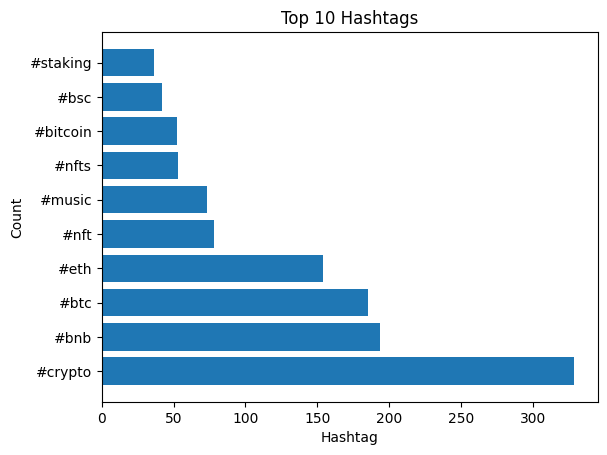

-------------------------------------------
Time: 2023-01-18 18:48:20
-------------------------------------------
('#crypto', 334)
('#btc', 159)
('#bnb', 156)
('#eth', 146)
('#music', 51)
('#bitcoin', 51)
('#nft', 49)
('#bsc', 33)
('#ethereum', 32)
('#cryptocurrency', 31)
...



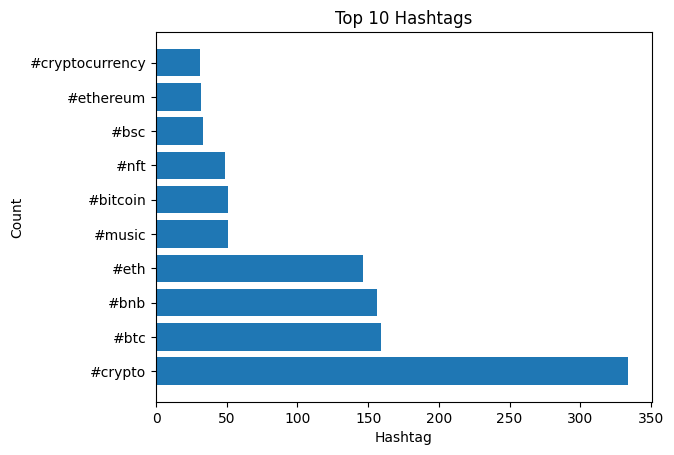

In [3]:
ssc.start()             # Start the computation 
#ssc.awaitTermination()  # Wait for the computation to terminate

In [4]:
ssc.stop()

23/01/18 18:48:30 ERROR ReceiverTracker: Deregistered receiver for stream 0: Stopped by driver


Exception in thread "receiver-supervisor-future-0" java.lang.Error: java.lang.InterruptedException: sleep interrupted
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1155)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.InterruptedException: sleep interrupted
	at java.lang.Thread.sleep(Native Method)
	at org.apache.spark.streaming.receiver.ReceiverSupervisor.$anonfun$restartReceiver$1(ReceiverSupervisor.scala:196)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurren